In [1]:
import re
import math
import time
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime

# 1.개요

1.1 배경  



# 2.목적

2.1 연구목적

1) 유투버 'AP투자연구소'의 단타매매기법을 분석하여 해당 기법의 타탕성을 검증하기 위함.

2.2 가설 
당일 주가는오르는 데 있어서 아래 1)~3)이 영향을 받을 것이다.
1) 당일 갭상승이 일어난다.
2) 당일 거래량이 전일(10영업일)거래량의 비해 폭발적인 증가가 일어난다.
3) 전일(10영업일) 저가의 추세가 상승중이다. 



# 3.과정

## 3.1 데이터 수집<br>

3.1.1 데이터 추출 사이트  
- 데이터 수집을 위해 AP투자연구소의 사이트에서 2019년~2023년 무료추천종목을 크롤링 하였다. <br>

- URL : http://www.fantastock.co.kr/<br>



3.1.2 함수  
- 크롤링을 위한 필요한 함수는 다음과 같다 

In [2]:
#URL을 통해 response 가져오기
def get_info_from_url(url):
    response = requests.get(
        url,
        headers={
        'User-Agent': 'Mozilla 5.0'
        }
    )
    bs = BeautifulSoup(response.text, 'lxml') 
    return bs

In [3]:
#게시판의 마지막 페이지를 찾는 함수
def get_lastpage_num(url):
    bs = get_info_from_url(url)
    count = len(bs.select('table>tr'))
    page = bs.select('.color-gray')[0].text.strip()
    page_num = math.ceil(int(re.findall('\d+',page)[0])/count)
    return page_num

3.1.3 데이터프레임화  
- 함수를 활용하여 크롤링한 데이터는 df 데이터프레임에 저장하였다.

In [4]:
#모든 년도 모든 페이지에 날짜 url 얻기
df = pd.DataFrame()
df_error = pd.DataFrame()
for year in tqdm(range(19,24)):
    url = f'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list{year}&page=1'
    last_page_num = get_lastpage_num(url)
    for page_num in tqdm(range(last_page_num + 1)):
        url = f'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list{year}&page={page_num}'
        bs = get_info_from_url(url)  
        info_from_bs = bs.select('table>tr')
        for bs in info_from_bs:
            try :
                date = bs.select('dd')[1].text
                url_link = bs.select('a')[0].get('href')
                bs = get_info_from_url(url_link)
                data_from_url = bs.select('.cmt_contents')

                for comments in data_from_url:
                    comment = comments.text

                    temp = pd.DataFrame({
                        'date': date,
                        'url': url_link,
                        'comment': comment
                        }, index=[0])

                    df = pd.concat([df, temp], axis=0)
            except IndexError:
                temp2 = pd.DataFrame({'url' : url})
                df_error = pd.concat([df_error, temp2], axis=0)

100%|██████████| 5/5 [09:43<00:00, 116.77s/it]


3.1.4 필터링  
- 주어진 데이터에서 필요한 부분은 comment 행의 종목명이다. 종목명 추출을 위해서 다음과 같이 필터링을 하였다.

In [8]:
#금일 추천주 필터링
df = df[df['comment'].str.contains('매수', na =False)]
df = df[df['comment'].str.contains('현재시간', na =False)]
df = df[df['comment'].str.contains('▶', na =False)]
df['comment'] = df.comment.apply(lambda x : re.sub('\\n','',x))

In [10]:
df.to_csv('data/new_df.csv', index=False, encoding='utf-8-sig')

3.1.5 추가 필터링
- comment 중에 '\x0' 와 같이 공백을 채우는 경우가 있어 추가적인 필터링을 하였다.

In [25]:
df = df.reset_index(drop=True)

In [26]:
df['slicing_comment'] = df.comment.apply(lambda x : re.findall('\d+분? ([가-힣A-z]+)',x))

In [27]:
df2 = df['slicing_comment'].apply(lambda x : x == [] )
df2[df2]

483    True
Name: slicing_comment, dtype: bool

In [28]:
df = df.drop(index= 483)

In [29]:
# 예외찾기
df['comment'] = df.comment.apply(lambda x : x.replace('\xa0',' '))
#종목 슬라이스
df['slicing_comment'] = df.comment.apply(lambda x : re.findall('\d+분? ([가-힣A-z]+)',x)[0])

In [30]:
df

,date,url,comment,slicing_comment
0,2019.12.27,http://www.fantastock.co.kr/bbs/board.php?bo_t...,▶ 현재시간 9시 00분 에스맥 현재가 1105원 기준 매수!!,에스맥
1,2019.12.27,http://www.fantastock.co.kr/bbs/board.php?bo_t...,▶ 현재시간 9시 01분 화천기계 현재가 3180원 기준 매수!!,화천기계
2,2019.12.27,http://www.fantastock.co.kr/bbs/board.php?bo_t...,▶ 현재시간 9시 02분 루미마이크로 현재가 1970원 기준 매수!!,루미마이크로
3,2019.12.26,http://www.fantastock.co.kr/bbs/board.php?bo_t...,▶ 현재시간 9시 00분 한국화장품 현재가 11400원 기준 매수!!,한국화장품
4,2019.12.26,http://www.fantastock.co.kr/bbs/board.php?bo_t...,▶ 현재시간 9시 01분 디앤씨미디어 현재가 16500원 기준 매수!!,디앤씨미디어
...,...,...,...,...
2915,2022.12.22,http://www.fantastock.co.kr/bbs/board.php?bo_t...,▶ 현재시간 9시 3분 팬오션 현재가 6050원 기준 매수!!,팬오션
2916,2022.12.21,http://www.fantastock.co.kr/bbs/board.php?bo_t...,▶ 현재시간 9시 6분 세종메디칼 현재가 3450원 기준 매수!!,세종메디칼
2917,2022.12.21,http://www.fantastock.co.kr/bbs/board.php?bo_t...,▶ 현재시간 9시 7분 청담글로벌 현재가 11350원 기준 매수!!,청담글로벌
2918,2022.12.19,http://www.fantastock.co.kr/bbs/board.php?bo_t...,▶ 현재시간 9시 0분 노터스 현재가 6250원 기준 매수!!,노터스


3.1.6 종목 추출
- 필터링 된 종목을 기준으로 날짜와 종목명을 필터링 하였다.
- 영어로 된 종목명들은 대문자로 이루어져 있기 때문에 추가적인 변환을 하였다.

In [31]:
#종목명 추출
recommended_stock = df.filter(items=['date','slicing_comment'])
recommended_stock = recommended_stock.rename(columns={'slicing_comment':'stock_name'})
#대소변환
recommended_stock['stock_name'] = recommended_stock.stock_name.str.upper()

In [32]:
recommended_stock

,date,stock_name
0,2019.12.27,에스맥
1,2019.12.27,화천기계
2,2019.12.27,루미마이크로
3,2019.12.26,한국화장품
4,2019.12.26,디앤씨미디어
...,...,...
2915,2022.12.22,팬오션
2916,2022.12.21,세종메디칼
2917,2022.12.21,청담글로벌
2918,2022.12.19,노터스


3.1.7 주가 정보 불러오기
- 한국투자 API 에서 제공하는 종목별 정도를 추출하였다.

In [35]:
#주가 기본정보 불러오기
Kospi_df = pd.read_csv('data/kospi_code.csv')
Kosdaq_df = pd.read_csv('data/kosdaq_code.csv')
#코스피 분류
kospi = Kospi_df.filter(items= ['단축코드','한글명'])
kospi['class'] = 'kospi'
#코스닥 분류
kosdaq = Kosdaq_df.filter(items= ['단축코드','한글종목명'])
kosdaq['class'] = 'kospi'
#주가 종목코드 불러오기
kospi = kospi.rename(columns={'단축코드':'stock_code','한글명' : 'stock_name'})
kosdaq = kosdaq.rename(columns={'단축코드':'stock_code','한글종목명' : 'stock_name'})
kospi_kosdaq = pd.concat([kospi,kosdaq])

3.1.8 종목합치기 
- recommended_stock과 kospi_kosdaq을 1차적으로 결합하였다.

In [36]:
#종목 코드 합치기(1차 추출)
stock = pd.merge(recommended_stock, kospi_kosdaq, how = 'left', on  = 'stock_name')
stock1 = stock.dropna()

In [37]:
stock1

,date,stock_name,stock_code,class
0,2019.12.27,에스맥,097780,kospi
1,2019.12.27,화천기계,010660,kospi
3,2019.12.26,한국화장품,123690,kospi
4,2019.12.26,디앤씨미디어,263720,kospi
5,2019.12.26,넥스트아이,137940,kospi
...,...,...,...,...
2914,2022.12.22,팬오션,028670,kospi
2915,2022.12.21,세종메디칼,258830,kospi
2916,2022.12.21,청담글로벌,362320,kospi
2917,2022.12.19,노터스,278650,kospi



3.1.9 예외 항목처리(생략)
- recommended_stock 종목중 사명이 바뀐경우와 상폐한 경우는 Nan값으로 입력되었기 때문에 따로 추출하여 직접 대조를 하였다.

In [176]:
exception = stock.drop(stock1.index,axis=0)
#파일로 저장
#exception.to_csv('exception2.csv', index=False, encoding='utf-8-sig')
#-------------직접파일로 작업-----------------
#파일불러오기
exception = pd.read_csv('./exception2.csv')
#Nan(상장폐지) 정리 및 주식코드6자리화
exception = exception.dropna()
exception['stock_code'] = exception.stock_code.apply(lambda x : str(int(x)).zfill(6))
#종목 코드 합치기(exception)
exception_kospi_kosdaq=kospi_kosdaq.drop(columns=['stock_name'])
exception = pd.merge(exception,exception_kospi_kosdaq,how = 'left', on  = 'stock_code')

In [177]:
exception = pd.read_csv('./exception2.csv')

In [179]:
exception['date']=exception.date.apply(lambda x : re.sub("-",".",x))

3.1.10 최종 종목코드 선정 
- 1차 추출 항목과 exception 항목을 결합하여 최종 종목을 선정하였다.

In [65]:
stock = stock1
stock['date'] = pd.to_datetime( stock1['date'])
stock = stock.sort_values(by=['date'], ascending=[True])

In [66]:
#중복항 삭제
stock = stock.drop_duplicates(subset=['date','stock_name'])

In [69]:
#추천 날짜 스트링 타입으로 변환
stock['end_date'] = stock.date.astype(str)
stock['end_date'] = stock.end_date.apply(lambda x : re.sub("-","",x))
stock = stock.reset_index(drop= True)

In [70]:
stock

,date,stock_name,stock_code,class,end_date
0,2019-06-04,고려시멘트,198440,kospi,20190604
1,2019-06-04,NICE평가정보,030190,kospi,20190604
2,2019-06-04,칩스앤미디어,094360,kospi,20190604
3,2019-06-05,대한항공우,003495,kospi,20190605
4,2019-06-07,알서포트,131370,kospi,20190607
...,...,...,...,...,...
2182,2023-02-21,대주산업,003310,kospi,20230221
2183,2023-02-22,대주산업,003310,kospi,20230222
2184,2023-02-23,팬오션,028670,kospi,20230223
2185,2023-02-24,나무가,190510,kospi,20230224


## 3.2 데이터 전처리

3.2.1 API 불러오기
- 한국투자증권의 API 에서 날짜는 문자열('yyyymmdd')로 인식하기 때문에 문자타입으로 변환 해주는 작업이 필요하다
- API의 보안키 발급 및 일자별 시세 검색의 함수는 다음과 같다

In [71]:
#한국투자 API 보안 인증키 발급 
APP_KEY = "PSDbkNNrIX3j60cW2MEFnBGZDZ1BzpgDxvC0"
APP_SECRET = "QfaZRX24K15ojO4yjG5o5dM+SUvJT4PYiK+tKKzgikyhmfrnTXoxOwn9rCf2hzXdtOhh4v3/O4bSFfQgS+u6ojdb6KgWuyub4GRraoWYaJTJyHSRqWUPab2GiCvrI/aIjx5S925MohrETq0k/eopFHgMInG0lmZdAh5TaegaZ1NDpNvPW8Y="
URL_BASE = "https://openapi.koreainvestment.com:9443"
PATH = "oauth2/tokenP"
URL = f"{URL_BASE}/{PATH}"

headers = {"content-type":"application/json"}
body = {"grant_type":"client_credentials",
        "appkey":APP_KEY, 
        "appsecret":APP_SECRET}

res = requests.post(URL, headers=headers, data=json.dumps(body))
ACCESS_TOKEN = res.json()["access_token"]

In [72]:
#일자별 시세 가져오기 (함수)
def get_info_from_kisapi(stock_code,end_date):
    time.sleep(0.1)
    
    st_date = pd.date_range(end = end_date,periods=20)[0]
    st_date = st_date.strftime("%Y%m%d")
    
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST03010100"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":stock_code,
        "FID_INPUT_DATE_1" : st_date,
        "FID_INPUT_DATE_2" : end_date,
        "FID_PERIOD_DIV_CODE" : "D",
        "FID_ORG_ADJ_PRC" : "1"
    }

    res = requests.get(URL, headers=headers, params=params)   
    res = res.json().get('output2')[0:11]
    res.reverse()
    return res

3.2.2 주가정보 불러오기
- 본 연구에서 각 종목에대한 정보는 갭상승(전일종가, 당일시가), 거래량(직전10일 거래량, 당일 거래량), 저점추세(직전 10일 저가)를 가져왔다.

In [73]:
#종목 일자별 데이터 가져오기 (함수)
def get_info_from_stock(res):
    temp = pd.DataFrame()
    day = 10
    for i in res:

        data = pd.DataFrame({
            'stck_oprc': i.get('stck_oprc'),
            'stck_clpr': i.get('stck_clpr'),
            'stck_hgpr': i.get('stck_hgpr'),
            'stck_lwpr': i.get('stck_lwpr'),
            'acml_vol': i.get('acml_vol')},
            index=[f'D{day}']
        )
        temp = pd.concat([temp,data])
        day -=1
    temp= temp.transpose()
    
    br_pr = temp.iloc[1:2, 9:10].reset_index(drop=True)
    br_pr.columns = 'br_pr_'+ br_pr.columns
    #당일시가
    tr_pr = temp.iloc[0:1, 10:].reset_index(drop=True)
    tr_pr.columns = 'tr_pr_'+ tr_pr.columns
    #당일고가
    tr_hpr = temp.iloc[2:3, 10:].reset_index(drop=True)
    tr_hpr.columns = 'tr_hpr_'+ tr_hpr.columns
    #거래량(10일)
    br_vol = temp.iloc[4:5, 0:10].reset_index(drop=True)
    br_vol.columns = 'Volume_'+ br_vol.columns
    #당일거래량
    tr_vol = temp.iloc[4:5, 10:].reset_index(drop=True)
    tr_vol.columns = 'tr_vol_'+ tr_vol.columns
    #저점(10일)
    br_lpr = temp.iloc[3:4, 0:10].reset_index(drop=True)
    br_lpr.columns = 'lpr_'+ br_lpr.columns
    #데이터 합치기 
    data = pd.concat([br_pr,tr_pr,tr_hpr,br_vol,tr_vol,br_lpr], axis=1)
    return data   

In [74]:
#전종목 가져오기
data = pd.DataFrame()
for i in range(len(stock)):
    try:
        end_date = stock.end_date[i]
        stock_code = stock.stock_code[i]
        res = get_info_from_kisapi(stock_code,end_date)
        temp = get_info_from_stock(res)
        data = pd.concat([data,temp],axis=0)
    except ValueError:
        print(i, stock_code)   
data = data.reset_index(drop = True)

In [75]:
#데이터 값 인트형으로 변환
data = data.fillna(0)
for cn in data.columns:
    data[f'{cn}'] = data[f'{cn}'].apply(lambda x : int(x))

In [81]:
#데이터 합치기
stock = pd.concat([stock, data], axis=1)

In [82]:
stock

,date,stock_name,stock_code,class,end_date,br_pr_D1,tr_pr_D0,tr_hpr_D0,Volume_D10,Volume_D9,...,lpr_D10,lpr_D9,lpr_D8,lpr_D7,lpr_D6,lpr_D5,lpr_D4,lpr_D3,lpr_D2,lpr_D1
0,2019-06-04,고려시멘트,198440,kospi,20190604,2215,2265,2875,31829,32512,...,2290,2300,2250,2205,2210,2210,2190,2210,2200,2170
1,2019-06-04,NICE평가정보,030190,kospi,20190604,14750,15900,18500,97323,141450,...,14750,14600,14450,14500,14400,13900,14100,13750,13800,14200
2,2019-06-04,칩스앤미디어,094360,kospi,20190604,10650,11200,12150,297968,330936,...,10450,10500,10500,10600,10450,10300,10150,9980,10200,10350
3,2019-06-05,대한항공우,003495,kospi,20190605,20600,22150,25500,62417,59988,...,21000,20600,20900,20100,20350,20200,19750,20000,20350,20500
4,2019-06-07,알서포트,131370,kospi,20190607,4000,4130,4755,3974024,2360155,...,2890,2875,2830,2880,2955,3175,3515,3565,3690,3790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,2023-02-21,대주산업,003310,kospi,20230221,2425,2460,2570,576027,675232,...,2350,2370,2340,2290,2395,2385,2325,2340,2305,2370
2183,2023-02-22,대주산업,003310,kospi,20230222,2520,2610,2700,675232,657051,...,2370,2340,2290,2395,2385,2325,2340,2305,2370,2445
2184,2023-02-23,팬오션,028670,kospi,20230223,6400,6470,6730,3278215,2258106,...,5890,5890,5770,6010,5980,5910,5860,5980,6000,6180
2185,2023-02-24,나무가,190510,kospi,20230224,17730,18090,18510,768817,413761,...,17090,16950,17170,16600,16900,16850,16650,17160,16850,16600


3.2.3 데이터에서 독립변수 설정
- 독립변수는 다음과 같다
- 갭상승률 : 전일종가 대비 당일 시가의 변화율
- 거래량상승률 : 직전 10일 거래량 평균 대비 당일 거래량 변화율
- 저점추세선 : 직전 10일 저가의 추세선 

In [99]:
#전일 종가 대비 당일 시가 증가율
stock['gap_change'] =stock.iloc[:,5:7].pct_change(axis=1).drop(columns= ['br_pr_D1'])

In [103]:
ex_volume = stock.iloc[:,8:18]

#이상치 범위 설정 
q3 = ex_volume.quantile(0.75, axis=1)
q1 = ex_volume.quantile(0.25, axis=1)

IQR = q3-q1
upper_limit = q3 + 1.5*IQR

#이상치 범위 변환
upper_limit = pd.DataFrame(upper_limit).to_numpy()
ex_volume = ex_volume.to_numpy()
ex_volume = np.where(ex_volume>upper_limit,np.nan,ex_volume)
ex_volume = pd.DataFrame(ex_volume)
stock['mean_vlome'] = ex_volume.mean(axis=1)
stock['today_vlome'] = stock['tr_vol_D0']
stock['vlome_change'] = stock.iloc[:,30:].pct_change(axis=1)['today_vlome']

In [126]:
#저가 회귀식 기울기 구하기 
parameter = stock.iloc[:,19:29]
parameter = parameter.T
for i in range(len(parameter.columns)):
    name = f'price{i}' 
    parameter = parameter.rename(columns={i:name})

parameter = parameter.reset_index().drop(columns=['index'])
parameter = parameter.reset_index()

data2=pd.DataFrame()
for i in range(0,len(stock)):
    model = sm.OLS.from_formula(f'index ~ price{i}', parameter).fit()
    slope = model.params[f'price{i}']
    temp = pd.DataFrame({'slope': slope} ,index =[i])
    data2 = pd.concat([data2,temp])

stock['slope'] = data2

In [129]:
stock.iloc[:,29:34]

,gap_change,mean_vlome,today_vlome,vlome_change,slope
0,0.02257,62419.30000,2704723,42.33152,-0.06173
1,0.07797,137174.00000,1302511,8.49532,-0.00718
2,0.05164,324424.75000,1916422,4.90714,-0.01078
3,0.07524,49189.11111,1163247,22.64847,-0.00436
4,0.03250,4247627.33333,32376808,6.62233,0.00743
...,...,...,...,...,...
2182,0.01443,798932.00000,5360228,5.70924,-0.00865
2183,0.03571,969706.12500,15390578,14.87138,0.01924
2184,0.01094,2682487.88889,5219155,0.94564,0.01777
2185,0.02030,620805.80000,1758732,1.83298,-0.00598


3.2.4 데이터에서 종속변수 설정
- 종속변수는 당일 상승여부 이다.
- 상승여부 :  당일 시가 대비 고가가 상승 했으면 1, 하락 했으면 0

In [130]:
#당일 고가 대비 시가 차이
stock['day_change'] = stock['tr_hpr_D0'] - stock['tr_pr_D0']
#당일 고가대비 시가 차이 (상승1 하락0)
stock['deter_change'] = stock.day_change.apply(lambda x : 1 if x > 0 else 0)

In [133]:
stock.iloc[:,34:]

,day_change,deter_change
0,610,1
1,2600,1
2,950,1
3,3350,1
4,625,1
...,...,...
2182,110,1
2183,90,1
2184,260,1
2185,420,1


3.2.5 독립변수와 종속 변수 결합
- 구해진 독립변수와 종속변수는 다음과 같다

In [135]:
stock_data = stock.iloc[:,29:]
stock_data

,gap_change,mean_vlome,today_vlome,vlome_change,slope,day_change,deter_change
0,0.02257,62419.30000,2704723,42.33152,-0.06173,610,1
1,0.07797,137174.00000,1302511,8.49532,-0.00718,2600,1
2,0.05164,324424.75000,1916422,4.90714,-0.01078,950,1
3,0.07524,49189.11111,1163247,22.64847,-0.00436,3350,1
4,0.03250,4247627.33333,32376808,6.62233,0.00743,625,1
...,...,...,...,...,...,...,...
2182,0.01443,798932.00000,5360228,5.70924,-0.00865,110,1
2183,0.03571,969706.12500,15390578,14.87138,0.01924,90,1
2184,0.01094,2682487.88889,5219155,0.94564,0.01777,260,1
2185,0.02030,620805.80000,1758732,1.83298,-0.00598,420,1


# 4.결과해석

## 4.1 산전도
- 구해진 변수들의 산전도를 분석하면 다음과 같다. 

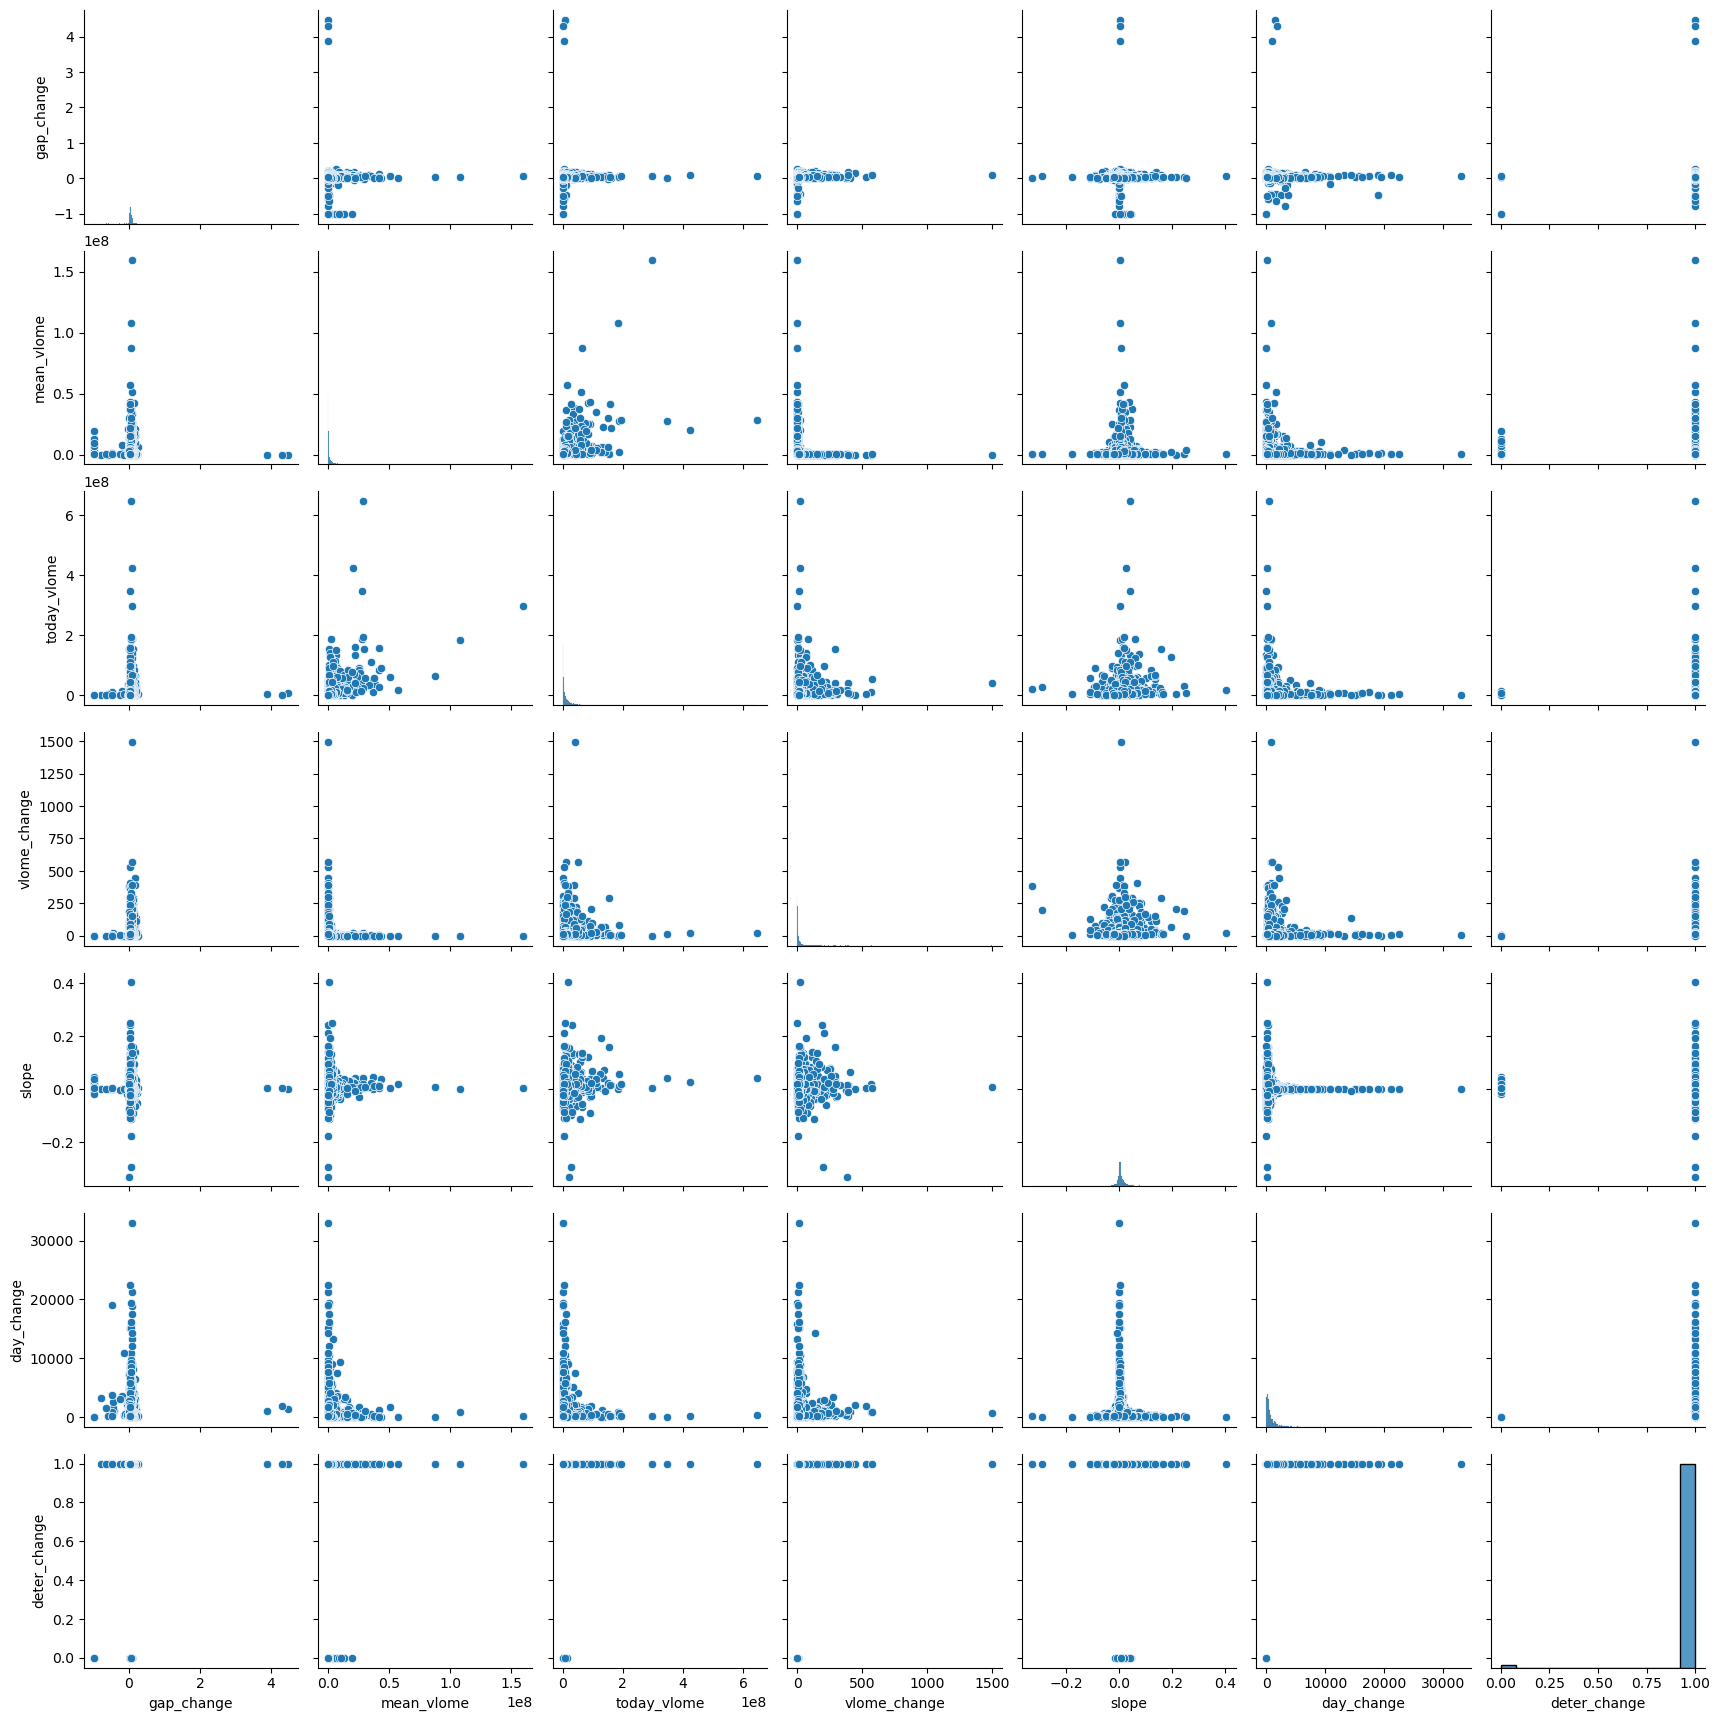

In [136]:
%matplotlib inline
sns.pairplot(stock_data)

## 4.2 로지스틱 회귀분석

- 회귀분석 결과는 다음과 같다

In [138]:
inf_index = stock_data.query('vlome_change>100000000').index
stock_data = stock_data.drop(index = inf_index)

In [143]:
stock_data

,gap_change,mean_vlome,today_vlome,vlome_change,slope,day_change,deter_change
0,0.02257,62419.30000,2704723,42.33152,-0.06173,610,1
1,0.07797,137174.00000,1302511,8.49532,-0.00718,2600,1
2,0.05164,324424.75000,1916422,4.90714,-0.01078,950,1
3,0.07524,49189.11111,1163247,22.64847,-0.00436,3350,1
4,0.03250,4247627.33333,32376808,6.62233,0.00743,625,1
...,...,...,...,...,...,...,...
2182,0.01443,798932.00000,5360228,5.70924,-0.00865,110,1
2183,0.03571,969706.12500,15390578,14.87138,0.01924,90,1
2184,0.01094,2682487.88889,5219155,0.94564,0.01777,260,1
2185,0.02030,620805.80000,1758732,1.83298,-0.00598,420,1


In [187]:
stock_data = stock_data.dropna()

In [188]:
Y = stock_data['deter_change']
X = stock_data[['gap_change', 'mean_vlome', 'today_vlome', 'vlome_change', 'slope']]

In [189]:
X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.022167
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                 2177
Model:                          Logit   Df Residuals:                     2171
Method:                           MLE   Df Model:                            5
Date:                Mon, 27 Feb 2023   Pseudo R-squ.:                  0.6680
Time:                        16:49:55   Log-Likelihood:                -48.258
converged:                       True   LL-Null:                       -145.36
Covariance Type:            nonrobust   LLR p-value:                 4.942e-40
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.9335      0.490      8.034      0.000       2.974       4.893
gap_change       6.175

In [192]:
Y = stock_data['deter_change']
X2 = stock_data[['gap_change','vlome_change', 'slope']]

In [193]:
X = sm.add_constant(X2)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.022593
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                 2177
Model:                          Logit   Df Residuals:                     2173
Method:                           MLE   Df Model:                            3
Date:                Mon, 27 Feb 2023   Pseudo R-squ.:                  0.6616
Time:                        17:00:14   Log-Likelihood:                -49.184
converged:                       True   LL-Null:                       -145.36
Covariance Type:            nonrobust   LLR p-value:                 1.899e-41
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.1026      0.424      9.674      0.000       3.271       4.934
gap_change       6.475